## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
unique_users = df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [5]:
df.converted.sum() / unique_users

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.
> This is important to fix as it would defeat the purpose of a treatment/control group

In [6]:
incorrect_treatment = df.query("group == 'treatment' & landing_page != 'new_page'").shape[0]
incorrect_control = df.query("group == 'control' & landing_page != 'old_page'").shape[0]

incorrect_treatment + incorrect_control

3893

f. Do any of the rows have missing values?
#### No, all the columns are whole.

In [7]:
df.shape[0] - df.count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query("(group == 'treatment' & landing_page == 'new_page') | (group == 'control' & landing_page == 'old_page')")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplic = df2[df2.user_id.duplicated()]
duplic.user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
duplic

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset="user_id")

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.sum() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control = df2[df2["group"] == "control"]
control.converted.sum() / control.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment = df2[df2["group"] == "treatment"]
treatment.converted.sum() / treatment.shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2["landing_page"] == "new_page").sum() / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> There isn't sufficient evidence to suggest that the treatment page leading to more conversions is statistically significant, and that the results given by the sample of conversions we have are not biased, due to factors such as change aversion or novelty effect. Or that the results are merely due to chance.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> **$H_{0}$** : **$p_{new}$** - **$p_{old}$** ≤ 0 **$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2["converted"].sum() / df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2[df2.group == "treatment"].shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.shape[0] - n_new
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1 - p_new])
pie_new = new_page_converted.sum() / n_new

pie_new

0.11784460807927878

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1 - p_old])
pie_old = old_page_converted.sum() / n_old

pie_old

0.1196291146385451

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
pie_new - pie_old

-0.001784506559266319

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# Calculating the proportions of successes for both groups over 10000 sims
new_page_converted = np.random.binomial(n_new, p_new, 10_000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10_000)/n_old

# building the sampling distribution for the difference in proportions
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

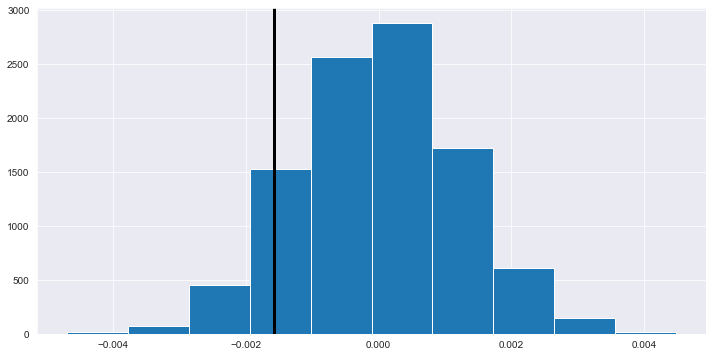

In [26]:
#Conversion (prop)ortions for each independent sample
new_prop = df2.query("landing_page == 'new_page'").converted.mean()
old_prop = df2.query("landing_page == 'old_page'").converted.mean()

obs_diff = new_prop - old_prop

plt.subplots(figsize=(12, 6))

plt.hist(p_diffs)
plt.axvline(obs_diff, color="black", linewidth=3);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
np.array(p_diffs)
p_value = (p_diffs > obs_diff).mean()
p_value

0.9034

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> the value computed above is known as a p-value in scientific studies. It describes the probability of having the observed sample statistic of difference in proportions coming from the hypothesised null value. And the significance of this value regarding whether or not to reject the null hypothesis is manifested when the probability of observing our sample statistic crosses the threshold at which we no longer tolerate the potential of committing ***Type One Error***, and in such case we fail to reject the null hypothesis. Otherwise, we reject the null hypothesis in favor of the alternative.  
In our case, we're left with ***1 - p_value*** potential of committing ***Type Two Error***. In other words, the probability that our observed statistic having came from the null hypothesis is ***p_value***, which means there is sufficient evidence for us to conclude thet we fail to reject the null hypothesis and that there is actually no statistically significant evidence that the new page in the alternative hypothesis attracts more conversions.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
from statsmodels.stats.proportion import proportions_ztest

control_all = df2.query("group == 'control'")
treatment_all = df2.query("group == 'treatment'")

convert_old = control_all.converted.sum()
convert_new = treatment_all.converted.sum()

n_old = control_all.shape[0]
n_new = treatment_all.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [52]:
z_stat, p_value = proportions_ztest(count=np.array([convert_new, convert_old]),
                                    nobs=np.array([n_new, n_old]),
                                    alternative="larger")

critical_value = .0196
decision = (p_value > critical_value)

if decision:
    print("Fail to reject the null hypothesis")
else:
    print("reject the null hypothesis")

Fail to reject the null hypothesis


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> the z-statistic here, means, how many standard deviations above or below the assumed null value, is the difference in sample proportions. And if this value is within the boundaries of a 95% confidence interval, we'd have evidence to conclude that we "fail to reject the null hypothesis", because *z-statistic* is *p-value* likely to have came from the distribution under the null, and that there is no statistically significant result to suggest that the new page attracts more conversions. Whether we have bootstraped with a binomial distribution or have conducted a traditional one-tailed two-sample-z-test, the results are similar in which we fail to reject the null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Because we're dealing with two possible outcomes of a categorical variable, and to favorably, constrain the limit of our predictions, an appropriate regression approach is Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
#Creating a copy of the original df to allocate for our regression workflow
df_log = df.copy()

df_log["intercept"] = 1

#Creating dummy variable(s) to use in the model
df_log = df_log.join(pd.get_dummies(df_log["landing_page"])).drop("old_page", axis=1).rename(columns={"new_page":"ab_page"})
    
df_log.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
from statsmodels.api import Logit
log_model = Logit(df_log["converted"], df_log[["intercept", "ab_page"]]).fit()

Optimization terminated successfully.
         Current function value: 0.366242
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
log_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              215704.5581
Date:               2022-02-06 20:19 BIC:              215725.7440
No. Observations:   294478           Log-Likelihood:   -1.0785e+05
Df Model:           1                LL-Null:          -1.0785e+05
Df Residuals:       294476           LLR p-value:      0.17120    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9879    0.0080  -248.3052  0.0000  -2.0036  -1.9722
ab_page      -0.0155    0.0114    -1.3683  0.1712  -0.0378   0.0067
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

> Here, the p-value of 0.17 is greater than a reasonable threshold for Type-one Error. Suggesting a statistically non-significant result, and that we "fail to reject the null hypothesis".  
  
#### The reason why there is a difference in the p-value calculated here vs. Part II, although they share the same bottom line:  
- With Part II, the p-value is the probability of **observing** our statistic or one more extreme when the null is true.
- With Logistic regression, the p-value is the probability of **observing** our z-statistic(the proximity in terms of standard deviations from the centralised null value from which we were able to observe our statistic).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>The ability to control for potentially other influencing factors could help us discover/eliminate bias and/or confounding variables.  
A disadvantage, however, to adding more predictors to our regression model is when we have a relatively small sample of data, in which case, a test might need to be ran for longer periods of time in order to collect more data.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df_log.set_index('user_id'), how='inner')

In [34]:
# Creating the necessary dummy variables and
# using lowercase column names for best practices
df_new = df_new.join(pd.get_dummies(df_new["country"]).rename(mapper=lambda x: x.lower(), axis=1))

In [35]:
#Fitting and getting an overview of the summary for the model
extra_effect_log = Logit(df_new["converted"], df_new[["intercept", "ab_page", "ca", "uk"]]).fit().summary2()
extra_effect_log

Optimization terminated successfully.
         Current function value: 0.366634
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              221649.9026
Date:               2022-02-06 20:19 BIC:              221692.3789
No. Observations:   302266           Log-Likelihood:   -1.1082e+05
Df Model:           3                LL-Null:          -1.1082e+05
Df Residuals:       302262           LLR p-value:      0.17864    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9856    0.0087  -228.1889  0.0000  -2.0027  -1.9686
ab_page      -0.0172    0.0112    -1.5339  0.1251  -0.0391   0.0048
ca           -0.0354    0.0263    -1.3461  0.1783  -0.0869   0.0161
uk            0.0086    0.0130     0.6626  0.5076  -0.0169   0.0342
==================================================================

"""

In [36]:
#computing the multiplicative change in odds for the coefficients
page = (-0.0172)
ca = (-0.0354)
uk = (0.0086)
np.exp(page), np.exp(ca), np.exp(uk)

(0.9829470755595455, 0.965219251329198, 1.008637086237646)

In [37]:
#computing the reciprocal for page and ca
1/np.exp(ca), 1/np.exp(page)

(1.0360340395437675, 1.0173487717339684)

>A subject from US is (1.036, CA) or (1.017, UK) more likely to convert. Holding all other variables constant.  
  
>The p values for the country suggest that conversions rely, to some extent, on the country of which the subject in the experiment is from.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
#Creating interaction columns for the new model
df_new["page*us"] = df_new["us"] * df_new["ab_page"]
df_new["page*ca"] = df_new["ca"] * df_new["ab_page"]
df_new["page*uk"] = df_new["uk"] * df_new["ab_page"]

In [47]:
interaction_log = Logit(df_new.converted, df_new[["intercept", "ab_page", "ca", "uk", "page*uk", "page*ca"]]).fit()
interaction_log.summary2()

Optimization terminated successfully.
         Current function value: 0.366628
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              221650.5779
Date:               2022-02-06 21:09 BIC:              221714.2922
No. Observations:   302266           Log-Likelihood:   -1.1082e+05
Df Model:           5                LL-Null:          -1.1082e+05
Df Residuals:       302260           LLR p-value:      0.14385    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9818    0.0094  -210.4413  0.0000  -2.0003  -1.9634
ab_page      -0.0248    0.0134    -1.8542  0.0637  -0.0510   0.0014
ca           -0.0135    0.0368    -0.3671  0.7135  -0.0857   0.0587
uk           -0.0108    0.0184    -0.5842  0.5591  -0.0469   0.0253
page*uk       0.0390    0.0261     1.4953  0.1348  -0.0121   0.0901
page*ca      -0.0441    0.0526    -0.8390  0.4014  -0.1471   0.0589
==================================================================

"""

<a id='conclusions'></a>
## Conclusions

- We fail to reject the null given the predictors being either the country or the landing pages.<br>
<br>
- the interaction term associated with subjects from country "UK" is more impactful for explaining the response than subjects from country "CA" when compared to "US" baseline. This means subjects from "UK" are more likely to convert when recieving the treatment page.<br>
<br>
- Subjects from country "UK" were less pridicting of the response compared to "US" baseline, before adding its interaction term. which could account for an instance of Simpson's Paradox.<br>
<br>
- based on conducting this A/B test, by controlling for different factors that predict the response, we could conclude that the R&D in the E-commerce website, is better off sticking with the old page, having that there is no statistically significant outcome to suggest that the new page is better in attracting paying customers.